In [152]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import scipy.stats as st

from sklearn import tree
from sklearn import naive_bayes
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tempfile import mkdtemp
import sys
sys.path.append('/content/drive/My Drive/Colab/Data-Mining Project')
from TScoreSelection import TScoreSelection
import warnings
warnings.filterwarnings("ignore")



In [153]:
def load_data():
    '''
        Load data from CSV file
        returns X,Y and random seeds
    '''
    dataFrame = pd.read_csv('/content/drive/My Drive/Colab/Data-Mining Project/pp5i_train.gr.csv')
    dataFrame.set_index('SNO', inplace=True)
    dataFrame = dataFrame.transpose()
    dataFrame.reset_index(drop=True, inplace=True)

    y = pd.read_csv('/content/drive/My Drive/Colab/Data-Mining Project/pp5i_train_class.txt')
    dataFrame = pd.concat([dataFrame, y], axis=1)
    myRndSeeds = 72
    dataFrame = dataFrame.sample(
        frac=1, random_state=myRndSeeds).reset_index(drop=True)
    print(dataFrame.shape)
    print(dataFrame.head())

    X = dataFrame.drop('Class', axis=1)

    y = dataFrame['Class']

    return X, y, myRndSeeds

In [154]:
def clean_data(X):
    '''
        Thresholding both train and test data 
        to a minimum value of 20, maximum of 16,000.
    '''
    X.clip(upper=16000, lower=20, inplace=True)
    print(X.shape)
    X = X.loc[:, X.max() - X.min() > 2]
    print(X.shape)
    return X

In [155]:
# Loading Dataset
X, y, myRndSeeds = load_data()

# Cleaning Dataset
X = clean_data(X)

# Feature selection using Ttest
cachedir = mkdtemp()
pipe = Pipeline([('featureSelection', TScoreSelection(w=10)),
                  ('classify', KNeighborsClassifier(n_neighbors=1))],
                memory=cachedir)

# Top Gene Selection
N_GENES = [2, 4, 6, 8, 10, 12, 15, 20, 25, 30]
N_LAYERS = [(32,), (64,), (128,)]

# Hyperparameter Optimization
tuned_parameters = [
    # KNN Classifier(2,3,4)
    {'featureSelection__w': N_GENES,
      'classify': [KNeighborsClassifier()],
      'classify__n_neighbors': [2, 3, 4]
      },
    # Decision Tree Classifier(J48 algorithm)
    {'featureSelection__w': N_GENES,
      'classify': [tree.DecisionTreeClassifier()],
      'classify__criterion':['gini', 'entropy'],
      'classify__min_samples_leaf': [1, 3, 5],
      'classify__max_depth': [3, 6, 9],
      'classify__presort': [True]
      },
    # Neural Network Multi-label Classifier
    {'featureSelection__w': N_GENES,
      'classify': [MLPClassifier()],
      'classify__hidden_layer_sizes': N_LAYERS,
      'classify__activation': ['logistic'],
      'classify__alpha':[0.05, 0.01, 0.005, 0.001],
      'classify__max_iter':[1000],
      'classify__solver': ['lbfgs'],
      'classify__verbose': [True]
      },
    # Naïve Bayes Classifier
    {'featureSelection__w': N_GENES,
      'classify': [naive_bayes.GaussianNB()]
      },
    # AdaBoost Classifier
    {'featureSelection__w': N_GENES,
      'classify': [AdaBoostClassifier()]
      }
]

# Model Selection using Pipeline and Cross validation
kfolds = KFold(n_splits=5, shuffle=True, random_state=myRndSeeds)
model = GridSearchCV(pipe, tuned_parameters, cv=kfolds,
                      return_train_score=True)
model.fit(X, y)
results = pd.DataFrame(model.cv_results_)

(69, 7071)
   A28102_at  AB000114_at  AB000115_at  ...  M71243_f_at  Z78285_f_at  Class
0         26           26           14  ...           26           -2    MED
1         23           24            9  ...           35           -4    MED
2         11           54            5  ...           28           15    MED
3         35           27           19  ...           36          -20    RHB
4         68           21           35  ...           27           -1    JPA

[5 rows x 7071 columns]
(69, 7070)
(69, 6746)


In [167]:
results[['mean_train_score','mean_test_score']]

,mean_train_score,mean_test_score
0,0.963766,0.842857
1,0.974610,0.885714
2,0.981883,0.884615
3,0.978247,0.870330
4,0.978182,0.884615
...,...,...
345,0.787338,0.531868
346,0.996429,0.753846
347,0.996429,0.752747
348,0.996429,0.767033


In [168]:
 results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify,param_classify__n_neighbors,param_featureSelection__w,param_classify__criterion,param_classify__max_depth,param_classify__min_samples_leaf,param_classify__presort,param_classify__activation,param_classify__alpha,param_classify__hidden_layer_sizes,param_classify__max_iter,param_classify__solver,param_classify__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
236,2.850588,0.282767,0.015304,0.004962,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,15,NaN,NaN,NaN,NaN,logistic,0.05,"(128,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.857143,1.000000,0.928571,0.928571,1.0,0.942857,0.053452,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
226,2.157164,0.243395,0.012608,0.000673,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,15,NaN,NaN,NaN,NaN,logistic,0.05,"(64,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.857143,1.000000,0.928571,0.928571,1.0,0.942857,0.053452,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
284,1.280823,0.180511,0.008757,0.001920,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,10,NaN,NaN,NaN,NaN,logistic,0.005,"(64,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.928571,0.928571,0.928571,0.928571,1.0,0.942857,0.028571,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
266,3.159941,0.339470,0.015841,0.005731,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,15,NaN,NaN,NaN,NaN,logistic,0.01,"(128,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.785714,1.000000,0.928571,0.928571,1.0,0.928571,0.078246,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
12,0.057533,0.000547,0.007271,0.000269,"KNeighborsClassifier(algorithm='auto', leaf_si...",3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'classify': KNeighborsClassifier(algorithm='a...,0.857143,0.928571,0.928571,0.928571,1.0,0.928571,0.045175,4,0.981818,0.981818,0.981818,0.981818,0.964286,0.978312,0.007013


In [169]:
 results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify,param_classify__n_neighbors,param_featureSelection__w,param_classify__criterion,param_classify__max_depth,param_classify__min_samples_leaf,param_classify__presort,param_classify__activation,param_classify__alpha,param_classify__hidden_layer_sizes,param_classify__max_iter,param_classify__solver,param_classify__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
236,2.850588,0.282767,0.015304,0.004962,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,15,NaN,NaN,NaN,NaN,logistic,0.05,"(128,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.857143,1.000000,0.928571,0.928571,1.0,0.942857,0.053452,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
226,2.157164,0.243395,0.012608,0.000673,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,15,NaN,NaN,NaN,NaN,logistic,0.05,"(64,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.857143,1.000000,0.928571,0.928571,1.0,0.942857,0.053452,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
284,1.280823,0.180511,0.008757,0.001920,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,10,NaN,NaN,NaN,NaN,logistic,0.005,"(64,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.928571,0.928571,0.928571,0.928571,1.0,0.942857,0.028571,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
266,3.159941,0.339470,0.015841,0.005731,"MLPClassifier(activation='logistic', alpha=0.0...",NaN,15,NaN,NaN,NaN,NaN,logistic,0.01,"(128,)",1000,lbfgs,True,{'classify': MLPClassifier(activation='logisti...,0.785714,1.000000,0.928571,0.928571,1.0,0.928571,0.078246,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
12,0.057533,0.000547,0.007271,0.000269,"KNeighborsClassifier(algorithm='auto', leaf_si...",3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'classify': KNeighborsClassifier(algorithm='a...,0.857143,0.928571,0.928571,0.928571,1.0,0.928571,0.045175,4,0.981818,0.981818,0.981818,0.981818,0.964286,0.978312,0.007013


In [170]:
best_estimator_ = model.best_estimator_
best_estimator_

Pipeline(memory='/tmp/tmpwbxnzfh7',
         steps=[('featureSelection', TScoreSelection(w=15)),
                ('classify',
                 MLPClassifier(activation='logistic', alpha=0.05,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(64,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=True, warm_start=False))],
         verbose=False)

In [177]:
 name=str(best_estimator_.named_steps['classify']).split('(')[0]
 name

'MLPClassifier'

In [178]:
model.best_score_

0.9428571428571428

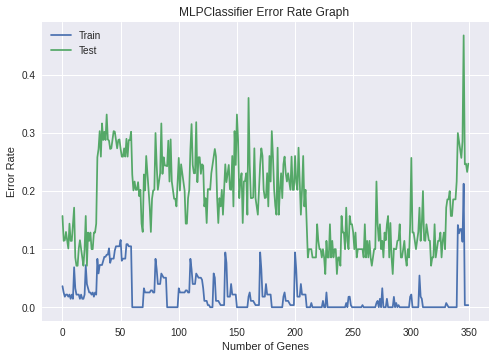

In [179]:
grid=model
alphas=np.arange(0,results.shape[0],1)
plt.title(name+" Error Rate Graph ")
plt.xlabel('Number of Genes')
plt.plot(alphas, 1-grid.cv_results_['mean_train_score'], label='Train')
plt.ylabel('Error Rate')
plt.plot(alphas, 1-grid.cv_results_['mean_test_score'], label='Test')
plt.legend()
plt.show()

In [180]:
testSet = pd.read_csv('/content/drive/My Drive/Colab/Data-Mining Project/pp5i_test.gr.csv')

In [181]:
testSet.set_index('SNO', inplace=True)
testX = testSet.transpose()
testX.reset_index(drop=True, inplace=True)

In [182]:
finalResult = pd.DataFrame()
finalResult['predicted'] = model.predict(testX)

In [183]:
finalResult

,predicted
0,MGL
1,MED
2,MGL
3,MED
4,EPD
5,RHB
6,MED
7,MED
8,MED
9,MED
